In [1]:
# EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn as sk
import pprint
# Math
from scipy.stats import loguniform
# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# Metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, recall_score, classification_report, matthews_corrcoef
# Scaling
from sklearn.preprocessing import StandardScaler
# Processing Data
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, RandomizedSearchCV, PredefinedSplit
from sklearn.model_selection import PredefinedSplit
# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
# Neural Nets
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from collections import Counter
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
# Counter
from collections import Counter
from collections import defaultdict
# Colab
from google.colab import files
# Resample
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
# Save
import joblib
import pickle


<h1><center><u>A Comparison Between Models and Sampling Methods for Imbalanced Fraudulent Credit Card Data</u></center></h1>

---
<n>

<center><h3><i>Does undersampling (Imblearn), oversampling (Smote), a mixture of the two, or using class weights improve the evaluation metrics for detecting credit card fraud? If so, which method proves best? First a comparison of models will be performed, with the highest performing model being used to fit the sampling methods.</i></h3></center>



In [2]:
# mount drive
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [3]:
# direction path 
images_dir = '/drive/My Drive/Colab Notebooks/Images'

In [4]:
# load dataset from Google Drive
df = pd.read_csv('/drive/My Drive/Colab Notebooks/creditcard.csv')

# <h2><center><u>Exploratory Data Analysis</u></center></h2><n>
<center><h3><i> The dataset has already been cleaned and a principle component analysis has been performed to reduce the dimensionality of the data, whilst also ensuring feature and user confidentiality. Two features remain in their original form; Time and Amount. <n> 
Below is an exploratory analysis of the data to help give insight into the data and how to approach futher feature engineering, feature scaling and sampling techniques </i></h3></center>

In [5]:
# #@title
# %%script echo skipping
# print first 3 indices of dataset
df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [6]:
# #@title
# %%script echo skipping
# check shape of the dataset
print(f' Total rows and columns: \n {df.shape}')

 Total rows and columns: 
 (284807, 31)


In [7]:
# #@title
# %%script echo skipping
# check for null values  - no null values to clean
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [8]:
# #@title
# %%script echo skipping
# check for the balance of data
print(f' Fraud vs. Non Fraud: \n {np.round(df["Class"].value_counts().sort_values() / len(df) * 100, 2)}')

 Fraud vs. Non Fraud: 
 1     0.17
0    99.83
Name: Class, dtype: float64


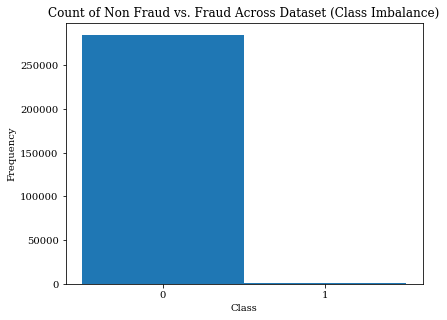

In [9]:
# #@title
# %%script echo skipping
# plot histogram to represent the class imbalance - Significant imbalance evident

plt.rcParams.update({'font.size':10, 'font.family':['Times New Roman'], 'xtick.bottom':True})
# seperately set font family
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['figure.figsize']  = [6.4, 4.8]
# xtick label rotation
ax = plt.gca()
ax.tick_params(axis='x', labelrotation = 0)

x = df['Class']
plt.hist(x, bins = range(3), align='left')
plt.title('Count of Non Fraud vs. Fraud Across Dataset (Class Imbalance)')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(range(2))
plt.savefig(f'{images_dir}/fraudVSnon-hist.png')
plt.show()


<center><h4><i> The graph above titled 'Count of Non Fraud vs Fruad (Class Imbalance)' represents the class imbalance between frauds commmited and legitmate credit card use. It is clear that the dataset is highly skewed towards non fraud cases. Therefor sampling methods will be needed to ensure the model does not overfit or entirely ignore fruad cases.</i></h4></center>

Class
0    22.00
1     9.25
Name: Amount, dtype: float64


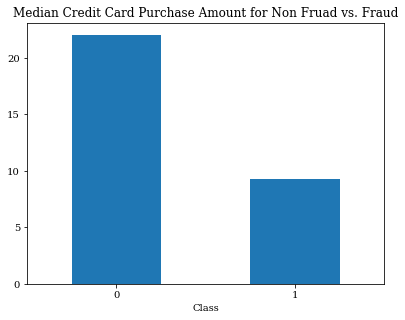

In [10]:
# #@title
# %%script echo skipping
# using groupby to calculate median amounts for each class
print(df.groupby('Class')['Amount'].median())
df.groupby('Class')['Amount'].median().plot.bar()
ax = plt.gca()
ax.tick_params(axis='x', labelrotation = 0)
plt.title('Median Credit Card Purchase Amount for Non Fruad vs. Fraud')
plt.savefig(f'{images_dir}/class-median-hist.png')

<center><h4><i> The graph above titled 'Median Credit Card Puchase Amount Non Fraud vs Fruad' represents the median credit card purchase amount between the two classes (non fraud vs. fraud). It illustrates that the half of all fraud cases are below roughly 10 USD. This could imply fraudsters keep fraudulant purchases to a minimum to avoid raising suspicion. </i></h4></center>

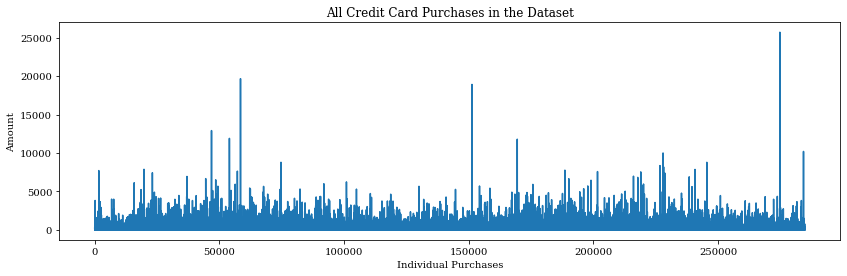

In [11]:
# #@title
# %%script echo skipping
# plot all credit card purchase amounts
df['Amount'].plot(figsize = (14, 4 ))
plt.title("All Credit Card Purchases in the Dataset")
plt.xlabel("Individual Purchases")
plt.ylabel("Amount")
plt.savefig(f'{images_dir}/amount-bar.png')
# noticeable outliers

<center><h4><i> The graph above titled 'All Credit Card Purchases in the Dataset' gives an overview of all purchase amounts, highlighting the various outliers in the dataset. </i></h4></center>

In [12]:
# #@title
# %%script echo skipping
# top 5 purchase amounts - peaks
print(f'The Transaction outliers/peaks shown above: \n {df["Amount"].sort_values(ascending=False,  ignore_index=True).head(5)}')

The Transaction outliers/peaks shown above: 
 0    25691.16
1    19656.53
2    18910.00
3    12910.93
4    11898.09
Name: Amount, dtype: float64


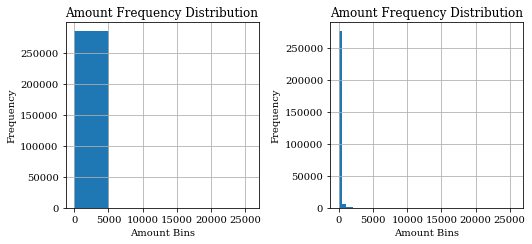

In [13]:
# #@title
# %%script echo skipping
# histogram comparison with varying bins to emphasis outliers
plt.rcParams['figure.figsize'] =  [7.50, 3.50]
plt.rcParams['figure.autolayout'] = True


bins_5 = df['Amount']
bins_50 = df['Amount']
fig, axes = plt.subplots(1,2)

axes[0].set_title('Amount Frequency Distribution')
axes[1].set_title('Amount Frequency Distribution')

for ax in axes.flat:
  ax.set(xlabel='Amount Bins', ylabel='Frequency')


bins_5.hist( ax=axes[0], bins = 5)
bins_50.hist( ax=axes[1], bins=50)


plt.savefig(f'{images_dir}/bin-comparison-amount-frequency')





<center><h4><i> The graphs above titled 'Amount Frequency Distributions' emphasises the skewness towards 0 of purchases amounts across various bin sizes. </i></h4></center>

In [14]:
# #@title
# %%script echo skipping
# The mean is significantly higher than the median - this is clear due to outliers
print(f' Max Amount: {df["Amount"].max()} \n Min Amount: {df["Amount"].min()} \n Mean Amount: {df["Amount"].mean()}')

 Max Amount: 25691.16 
 Min Amount: 0.0 
 Mean Amount: 88.34961925087359


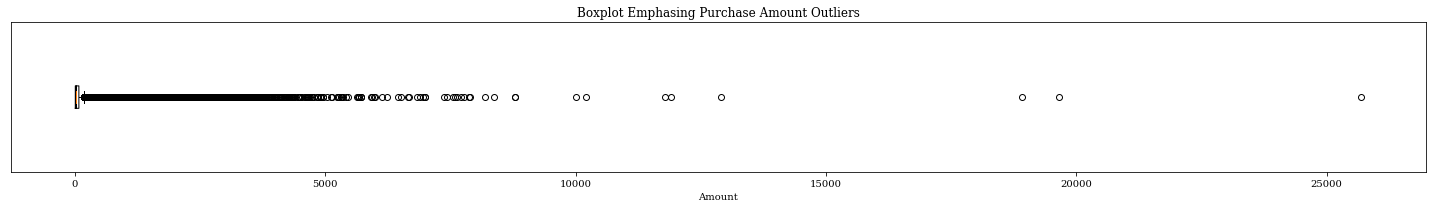

In [15]:
# #@title
# %%script echo skipping
# boxplot visualisation for outliers
plt.rcParams["figure.figsize"] = (20,3)
plt.boxplot(df['Amount'], notch=True, meanline=True, vert=False)
plt.title('Boxplot Emphasing Purchase Amount Outliers')
plt.xlabel('Amount')
plt.yticks([])
plt.savefig(f'{images_dir}/boxplot-amounts')


<center><h4><i> The graph above titled 'Boxplot Emphasising Purchase Amount Outliers' emphasises the upper fence outliers and a skewness towards zero of purchase amounts. </i></h4></center>

In [16]:
# #@title
# %%script echo skipping
# find all the outlier values
q1 = df['Amount'].quantile(0.25)
q3 = df['Amount'].quantile(0.75)
upper_fence = q3 + 1.5*q3
df_upper_extreme = df[df['Amount'] > upper_fence]


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


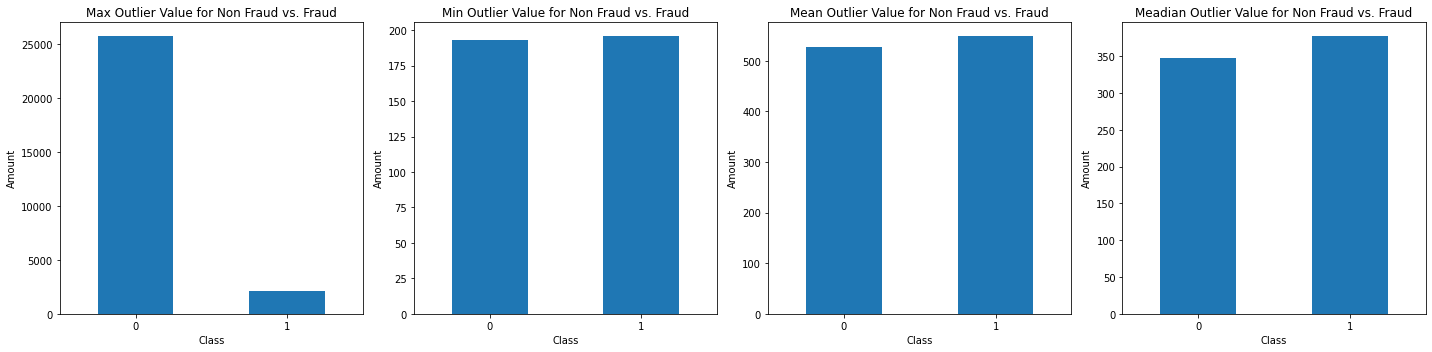

In [17]:
# #@title
# %%script echo skipping
# setting x,y vals
max = df_upper_extreme.groupby('Class')['Amount'].max()
min = df_upper_extreme.groupby('Class')['Amount'].min()
mean = df_upper_extreme.groupby('Class')['Amount'].mean()
median = df_upper_extreme.groupby('Class')['Amount'].median()

# params
plt.rcParams.update({'font.size':10, 'font.family':'Times New Roman', 'xtick.bottom':True, 'figure.figsize': [20, 5]})
 
# graph 1
plt.subplot(1,4,1)
max.plot.bar(title='Max Outlier Value for Non Fraud vs. Fraud', ylabel='Amount')
# change tick labels rotation
ax = plt.gca()
ax.tick_params(axis='x', labelrotation = 0)
# grapg 2
plt.subplot(1,4,2)
min.plot.bar(title='Min Outlier Value for Non Fraud vs. Fraud', ylabel='Amount')
# change tick labels rotation
ax = plt.gca()
ax.tick_params(axis='x', labelrotation = 0)
# graph 3
plt.subplot(1,4,3)
mean.plot.bar(title='Mean Outlier Value for Non Fraud vs. Fraud', ylabel='Amount')
# change tick labels rotation
ax = plt.gca()
ax.tick_params(axis='x', labelrotation = 0)
# graph 4
plt.subplot(1,4,4)
median.plot.bar(title='Meadian Outlier Value for Non Fraud vs. Fraud', ylabel='Amount')
# change tick labels rotation
ax = plt.gca()
ax.tick_params(axis='x', labelrotation = 0)

plt.savefig(f'{images_dir}/bargraphs-outlier-aggrs.png')
plt.show()

<center><h4><i> The graphs above titled 'Max/Min/Mean/Median Outlier Values for Non Fraud vs Fraud' illustrate that aggregate values do not differ significantly betweeen the two classes. Suggesting fraudsters are trying to hide their behaviour amongst usual user spending patterns.  </i></h4></center>

In [18]:
# #@title
# %%script echo skipping
# aggregate info
aggrs = df_upper_extreme.groupby('Class')['Amount'].agg(['max','min','median','mean'])
print(aggrs)

            max     min   median        mean
Class                                       
0      25691.16  192.93  347.000  526.279697
1       2125.87  195.66  377.095  548.390116


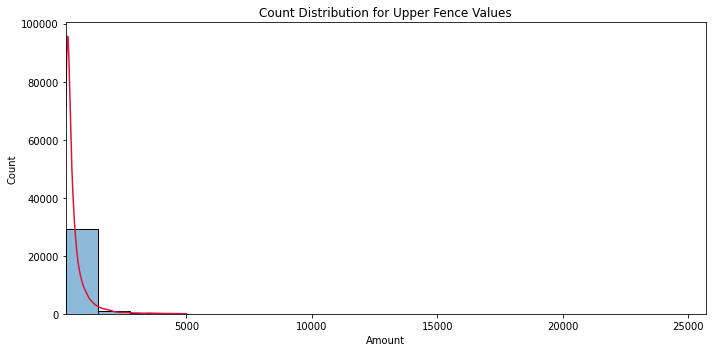

In [19]:
# #@title
# %%script echo skipping
# show distribution and skewness of the upper fence values towards 
plt.rcParams['figure.figsize'] = (10,5)
ax = sns.histplot(data=df_upper_extreme['Amount'], bins=20, kde=True, stat='count', kde_kws={'clip': (0.0, 5000)})
plt.margins(x=0)
plt.title("Count Distribution for Upper Fence Values")
ax.lines[0].set_color('crimson')
plt.savefig(f'{images_dir}/outlier-val-dist-skew-0.png')


<center><h4><i> The graphs above titled 'Count Distribution for Upper Fence Values' illustrates that the majority of upper fence outliers still skews towards zero, and that the larger purchase values are rare occurances. We will not remove these outliers, or use a RobustScalar scaling method to reduce the outlier behavior, because these purchases re representative of the overall population with regards to credit card usage and our model should take this behavior into consideration when fiting.   </i></h4></center>

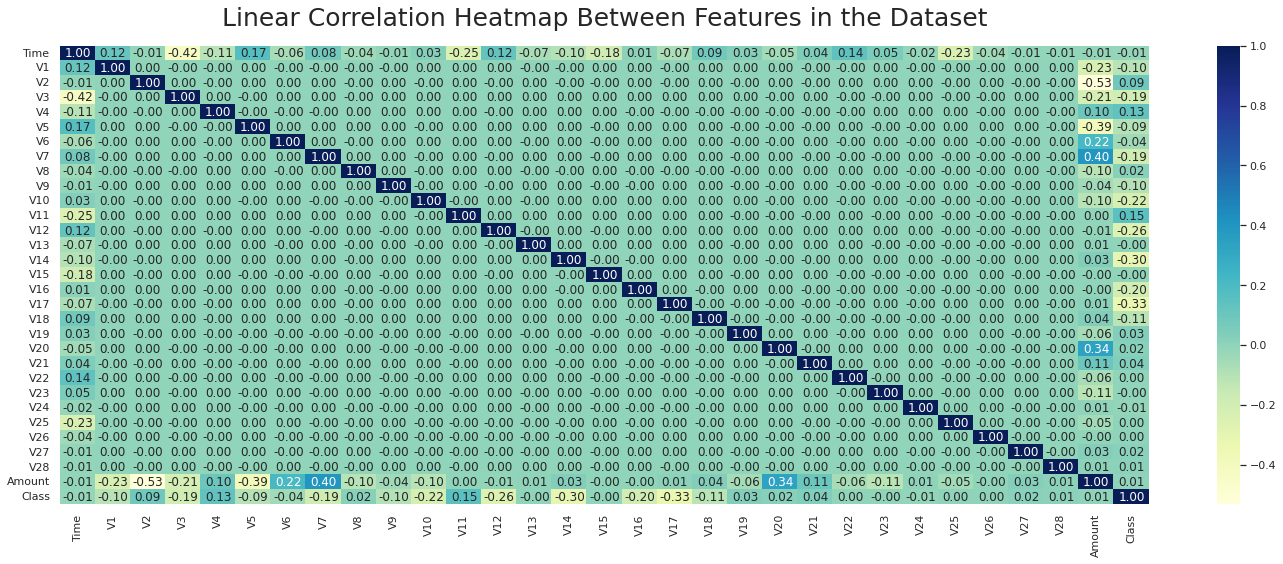

In [21]:
# #@title
# %%script echo skipping
# heatmap to illustrate correlation between features 
ax = plt.axes()
sns.heatmap(df.corr(),ax=ax, cmap='YlGnBu', annot=True, fmt='.2f')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
sns.set(rc = {'figure.figsize':(20,8)})
ax.set_title('Linear Correlation Heatmap Between Features in the Dataset', fontsize= 25, pad=20)
plt.savefig(f'{images_dir}/feature-correlation-heatmap.png')


 <center><h4><i> The heatmap above titled 'Linear Correlation Heatmap Between Features in the Dataset' illustrates the various linear correlations between all the features in the dataset. There is positive and negative linear correlations between the 'Class' feature and numerous other features, e.g. 'V10' with negative correlation of -0.22, 'V17' with a negative correlaton of -0.33 and 'V11' with a positive correlation of 0.15. There seems to be no linear correlation between the 'Class' and 'Time' features, as well as between 'Class' and the 'Amount' features. This is not to say there is no non linear relationships found between these features. When fine tuning the model, it might be worth investigating whether the performance of the models improves if the features were dropped.  </i></h4></center>



---



---



---



In [196]:

# #@title
# %%script echo skipping
# function for saving metric data to df and displaying/returning the df

model_eval = {
    'model': '',
    'mcc_test' : '',
    'recall_test' : '',
    'f1_score_test' : ''
}

def add_model_eval(model, mcc_test, recall_test, f1_score_test):
    model_eval['model'] = model
    model_eval['mcc_test'] =  f'{mcc_test: .2f}'
    model_eval['recall_test'] = f'{recall_test: .2f}'
    model_eval['f1_score_test'] = f'{f1_score_test: .2f}'
    # model_eval['mcc_test'] =  int(mcc_test)
    # model_eval['recall_test'] = int(recall_test)
    # model_eval['f1_score_test'] = int(f1_score_test)
 

def view_models_eval(df_results):
    
    
    df_results = df_results.append(model_eval, ignore_index=True)
    df_results = df_results.sort_values(by=['recall_test'], ascending=[False])
    # display
    # display(df_results.style.hide_index())

    return df_results

In [197]:
# #@title
# %%script echo skipping
df_metrics_table = pd.DataFrame()


# <h1><center><u>Imbalanced Dataset Models</u></center></h1><n>
<center><h3><i> The first iteration of models will keep the class imbalance ratios. These will be our benchmark models to test against when using over and undersampling</i></h3></center> 

# <h2><b>Feature Scaling</b></h2><n>
<h3><i> To keep the scaling consistent throughout the dataset, the  'Amount' and 'Time' features will also be standardized using the StandardScalar() method. Fit and transform on the training data first, and with these std/mean scores, fit onto the test data</i></h3>


In [164]:
# instantiate the scaler
scaler = StandardScaler()


# <h2><b>Train/Test Split</b></h2><n>
<h3><i> Keep the class imbalance consistent in our train/test splits by splitting between each class and the target and feature variables. Also, when doing cross-validation, use StratifiedKfold to keep class imbalance for each cross-validation folds.</i></h3>



In [165]:
# seperate target and feature variables
y = df['Class']
X = df.drop(['Class'], axis=1)

In [166]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=42, shuffle=True)

# split train further into a validation set for DNN
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=42, shuffle=True)


In [167]:
# standardize (fit + transform) training features first, to calculate the mean/std from training data. Fit this onto test dataset and validation dataset
X_train[['Time','Amount']] = scaler.fit_transform(X_train[['Time','Amount']])
X_train_std = X_train.copy()
# Standardize test features
X_test[['Time','Amount']] = scaler.transform(X_test[['Time','Amount']])
# Standardize
X_test_std = X_test.copy()

# Standarize training validation set for DNN
X_train_val[['Time','Amount']] = scaler.fit_transform(X_train_val[['Time','Amount']])
# Standardize
X_train_val_std = X_train_val.copy()

# Standardize test features
X_test_val[['Time','Amount']] = scaler.transform(X_test_val[['Time','Amount']])
# Standardize
X_test_val_std = X_test_val.copy()


<h2><b2>Confusion Matrix Function</h2></b>


In [29]:
# #@title
# %%script echo skipping
# illustrate with a confusion matrix test
def confusion_matrix_plot(cfm,flxt,title):

    sns.set(rc = {'figure.figsize':(5,5)})
    ax = sns.heatmap(cfm, annot=True, cmap='Blues', fmt='g')
    ax.set_title(f"Confusion Matrix for {title}\n\n");
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    # ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    # save
    plt.savefig(f"{images_dir}/confusion-matrix-{flxt}.png")
    
    # display the visualization of the Confusion Matrix.
    
    return plt.show()

<h3><b>Model Evaluation Metrics </b></h3>
<h4>Since the dataset label is extremely imbalanced, only 0.18% of instances in the dataset is fraud. Selecting an appropriate evaluation metrics is crucial as standard metrics work well on balanced dataset.</h4>

<h4>For example, using the accuracy as metrics for this dataset. A dummy model can just predict all the instances in the dataset as non-fraud and accuracy of the model will still be 99.82%. As 99.82% of the instances in the dataset are non-fraud.</h4>

<h4>Hence, selecting 'recall', 'f1-score', and the more obscure 'Matthews Coefficient' as the metrics to evaluate the following models, seem more appropriate. </h4><br><br>
<div align="left">
$$
{Recall}=\frac{True\text{ } Positive\ (TP)}{True\text{ } Positive\ (TP)+False\text{ }Negative\ (FN)}
$$
<br>
$$
{F1\text{ } Score}=\frac{2·Precision·Recall}{Precision + Recall}
$$
<br>
$$
{Matthews\text{ } Coefficient}=\frac{TP·TN-FP·FN}{\sqrt{TP+FP·TP+FN·TN+FP·TN+FN}}
$$
</div>
<br><br>


<h2><b>1. Logistic Regression - </b>Benchmark Model</h2>

In [30]:
# #@title
# %%script echo skipping
# logistic Regression
lr = LogisticRegression()

In [31]:
# #@title
# %%script echo skipping
# train model
lr.fit(X_train_std, y_train)

LogisticRegression()

In [32]:
# #@title
# %%script echo skipping
# prediction on training data
y_train_pred = lr.predict(X_train_std)
print(y_train_pred)

[0 0 0 ... 0 0 0]


In [33]:
# #@title
# %%script echo skipping
# confusion matrix + metrics (train)
cnf_matrix = metrics.confusion_matrix(y_train, y_train_pred)
print(cnf_matrix)
print(f'Logistic Regression (train) MCC: {metrics.matthews_corrcoef(y_train, y_train_pred)}')
print(f'Logistic Regression (train) F1: {metrics.f1_score(y_train,y_train_pred)}')
print(f'Logistic Regression (train) Recall: {metrics.recall_score(y_train, y_train_pred)}')

[[227420     31]
 [   142    252]]
Logistic Regression (train) MCC: 0.7543288383528208
Logistic Regression (train) F1: 0.7444608567208272
Logistic Regression (train) Recall: 0.6395939086294417


In [34]:
# #@title
# %%script echo skipping
# classification report 
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.89      0.64      0.74       394

    accuracy                           1.00    227845
   macro avg       0.94      0.82      0.87    227845
weighted avg       1.00      1.00      1.00    227845



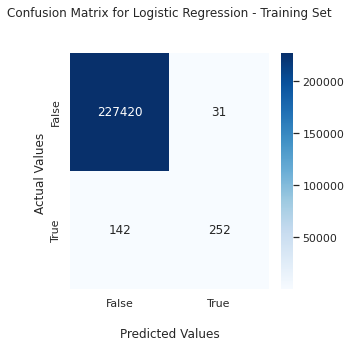

In [35]:
# #@title
# %%script echo skipping
# graphical confusion matrix for lg train set
confusion_matrix_plot(cnf_matrix, 'lg-train', 'Logistic Regression - Training Set')

In [36]:
# #@title
# %%script echo skipping
# predictions on test date
y_test_pred = lr.predict(X_test_std)
print(y_test_pred)

[0 0 0 ... 0 0 0]


In [37]:
# #@title
# %%script echo skipping
# confusion matrix for test data
cnf_matrix_test = metrics.confusion_matrix(y_test, y_test_pred)
print(cnf_matrix_test)
# metrics for test data
lr_mcc_test = metrics.matthews_corrcoef(y_test, y_test_pred) # store as var
lr_f1_test = metrics.f1_score(y_test,y_test_pred) # store as var
lr_recall_test = metrics.recall_score(y_test, y_test_pred) # store as var
print(f'Logistic Regression (test) MCC: {metrics.matthews_corrcoef(y_test, y_test_pred)}')
print(f'Logistic Regression (test) F1: {metrics.f1_score(y_test,y_test_pred)}')
print(f'Logistic Regression (test) Recall: {metrics.recall_score(y_test, y_test_pred)}')

[[56851    13]
 [   34    64]]
Logistic Regression (test) MCC: 0.7363585541572303
Logistic Regression (test) F1: 0.7314285714285713
Logistic Regression (test) Recall: 0.6530612244897959


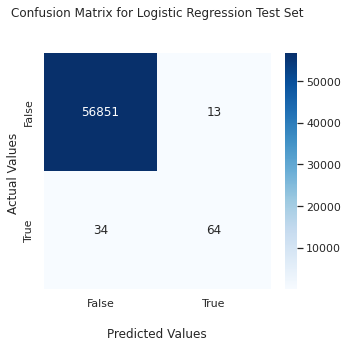

In [38]:
# #@title
# %%script echo skipping
# graphical confusion matrix for lg test set
confusion_matrix_plot(cnf_matrix_test, 'lg-test', 'Logistic Regression Test Set' )

In [198]:
# add Logistic Regression - Basline
add_model_eval('Logistic Regression',lr_mcc_test, lr_recall_test, lr_f1_test)
df_metrics_table = view_models_eval(df_metrics_table)
display(df_metrics_table)

,model,mcc_test,recall_test,f1_score_test
0,Logistic Regression,0.74,0.65,0.73


In [ ]:
# #@title
# %%script echo skipping
# # save model data to csv - google drive
# df_metrics_table.to_csv('/drive/My Drive/Colab Notebooks/model_results_table_new.csv', index = False)
# # open model data to pandas df - from
# df_metrics_table = pd.read_csv('/drive/My Drive/Colab Notebooks/model_results_table_new.csv',index_col=0, float_precision='round_trip')
# # df_metrics.drop(df_metrics.index, inplace=True)
# display(df_metrics_table)

In [88]:
#@title
%%script echo skipping
# using grid-search to fine-tune hyperparameters plus stratified cross-validation

# grid = dict(C=[10, 1.0, 0.1, 0.01,100], max_iter=[50,100,200])
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

grid_search =  RandomizedSearchCV(estimator=lr,  param_distributions=[
                                          {'solver': [ 'newton-cg','lbfgs'], 'penalty': ['l2','none'], 'C' : loguniform(1e-5, 100),'max_iter' : [50,100,400,4000]},
                                          {'solver': ['liblinear'], 'penalty': ['l2','l1'], 'C' : loguniform(1e-5, 100),'max_iter' : [50,100,400,4000]},
                                          {'solver': ['saga'], 'penalty':['l2','l1','elasticnet','none'], 'l1_ratio': [0.2, 0.4, 0.6, 0.8], 'C' : loguniform(1e-5, 100),'max_iter' : [50,100,400,4000]},
                                          {'solver': ['saga'], 'penalty':['l2','l1','none'],  'C' : loguniform(1e-5, 100),'max_iter' : [50,100,400,4000]}],
                                          n_jobs=-1, 
                                          cv=cv,
                                          scoring=["f1","recall"], refit='recall',error_score='raise')
grid_search.fit(X_train_std, y_train)

lr_best = grid_search.best_estimator_ 
print(lr_best)
best_params = grid_search.best_params_, grid_search.best_score_
print(best_params)

joblib.dump(best_params, '/drive/My Drive/Colab Notebooks//GS_params.pkl')



skipping


In [39]:
# #@title
# %%script echo skipping
# Open pickle file containing best grid params for Logistic Regression
lg_best_params = open('/drive/My Drive/Colab Notebooks//GS_params.pkl','rb')
best_params_lg_grid = pickle.load(lg_best_params)
print(best_params_lg_grid)

({'C': 4.64785910271863, 'max_iter': 4000, 'penalty': 'l2', 'solver': 'saga'}, 0.6370009737098344)


In [42]:
# #@title
# %%script echo skipping
lr_grid = LogisticRegression(C=4.64785910271863, penalty='l2', solver='saga', max_iter=4000)
lr_grid.fit(X_train_std, y_train)
# training set predictions
y_train_pred_grid = lr_grid.predict(X_train_std)
print(y_train_pred_grid)

[0 0 0 ... 0 0 0]


In [43]:
# #@title
# %%script echo skipping

# grid metrics on training data
print(f'Logistic Regression (grid-train) MCC: {matthews_corrcoef(y_train, y_train_pred_grid)}')
print(f'Logistic Regression (grid-train) recall: {recall_score(y_train, y_train_pred_grid)}') 
print(f'Logistic Regression (grid-train) F1 score: {f1_score(y_train, y_train_pred_grid)}\n')
print(f'Confusion Matrix (grid-train):\n\n {confusion_matrix(y_train, y_train_pred_grid)}\n\n')


# grid predictions on test data
y_test_pred_grid = lr_grid.predict(X_test_std)
print(f'Logistic Regression Predictions (grid-test): {y_test_pred_grid}\n')
# metrics
lr_mcc_test_grid = metrics.matthews_corrcoef(y_test, y_test_pred_grid) # store as var
lr_recall_test_grid = metrics.recall_score(y_test, y_test_pred_grid) # store as var
lr_f1_test_grid = metrics.f1_score(y_test,y_test_pred_grid) # store as var

print(f'Logistic Regression (grid-test) MCC: {lr_mcc_test_grid}')
print(f'Logistic Regression (grid-test) Recall: {lr_recall_test_grid}')
print(f'Logistic Regression (grid-test) F1 score: {lr_f1_test_grid}\n')
print(f'Confusion Matrix (grid-test):\n\n {confusion_matrix(y_test, y_test_pred_grid)}\n')

Logistic Regression (grid-train) MCC: 0.7543288383528208
Logistic Regression (grid-train) recall: 0.6395939086294417
Logistic Regression (grid-train) F1 score: 0.7444608567208272

Confusion Matrix (grid-train):

 [[227420     31]
 [   142    252]]


Logistic Regression Predictions (grid-test): [0 0 0 ... 0 0 0]

Logistic Regression (grid-test) MCC: 0.7295956683443172
Logistic Regression (grid-test) Recall: 0.6428571428571429
Logistic Regression (grid-test) F1 score: 0.7241379310344829

Confusion Matrix (grid-test):

 [[56851    13]
 [   35    63]]



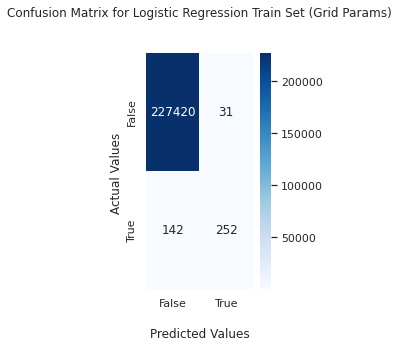

In [44]:
# #@title
# %%script echo skipping
# graphical confusion matrix for lg grid search train set
confusion_matrix_plot(confusion_matrix(y_train, y_train_pred_grid), 'lg-grid-train', 'Logistic Regression Train Set (Grid Params)' )

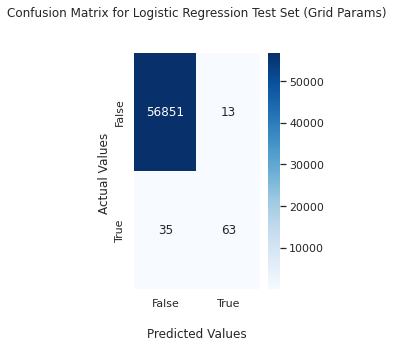

In [45]:
# #@title
# %%script echo skipping
# graphical confusion matrix for lg grid search test set
confusion_matrix_plot(confusion_matrix(y_test, y_test_pred_grid), 'lg-grid-test', 'Logistic Regression Test Set (Grid Params)' )

In [199]:
# add Logistic Regression - Grid
add_model_eval('Logistic Regression Grid',lr_mcc_test_grid, lr_recall_test_grid, lr_f1_test_grid)
df_metrics_table = view_models_eval(df_metrics_table)
display(df_metrics_table)

,model,mcc_test,recall_test,f1_score_test
0,Logistic Regression,0.74,0.65,0.73
1,Logistic Regression Grid,0.73,0.64,0.72


<h2><b>2. Random Forest</b></h2>

In [168]:
#@title
# #@title
# %%script echo skipping
rf = RandomForestClassifier()
rf.fit(X_train_std, y_train)

RandomForestClassifier()

In [169]:
#@title
# #@title
# %%script echo skipping
# predict on training data
y_train_pred = rf.predict(X_train_std)
# print training metrics
print(f'Random Forest (train) MCC: {matthews_corrcoef(y_train, y_train_pred)}')
print(f'Random Forest (train) recall: {recall_score(y_train, y_train_pred)}') 
print(f'Random Forest (train) F1 score: {f1_score(y_train, y_train_pred)}\n')

Random Forest (train) MCC: 0.9987279627409584
Random Forest (train) recall: 0.9974619289340102
Random Forest (train) F1 score: 0.9987293519695045



In [170]:
#@title
# #@title
# %%script echo skipping
# confusion matrix -train data- for Random Forest
cnf_matrix_train_rf = metrics.confusion_matrix(y_train, y_train_pred)
print(f'Random Forest Confusion Matrix (train):\n\n {cnf_matrix_train_rf}\n')

Random Forest Confusion Matrix (train):

 [[227451      0]
 [     1    393]]



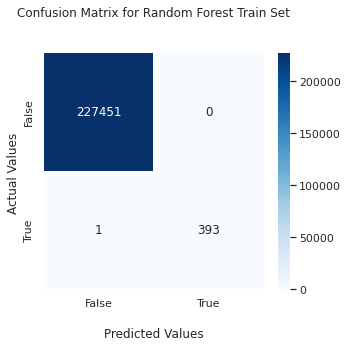

In [171]:
#@title
# #@title
# %%script echo skipping
# graphical confusion matrix for rf train set
confusion_matrix_plot(cnf_matrix_train_rf, 'rf-train', 'Random Forest Train Set' )

In [172]:
#@title
# #@title
# %%script echo skipping
# predict on the test data 
y_test_pred = rf.predict(X_test_std)
# save test metrics to variables and print
rf_mcc_test = metrics.matthews_corrcoef(y_test, y_test_pred) # store as var
rf_f1_test = metrics.f1_score(y_test,y_test_pred) # store as var
rf_recall_test = metrics.recall_score(y_test, y_test_pred) # store as var
print(f'Random Forest (test) MCC: {rf_mcc_test}')
print(f'Random Forest (test) RF recall: {rf_recall_test}')
print(f'Random Forest (test) F1 Score: {rf_f1_test}')


Random Forest (test) MCC: 0.8763368354437778
Random Forest (test) RF recall: 0.8163265306122449
Random Forest (test) F1 Score: 0.8743169398907105


In [173]:
#@title
# #@title
# %%script echo skipping
# confusion matrix test for Random Forest
cnf_matrix_test_rf = metrics.confusion_matrix(y_test, y_test_pred)
print(f'Random Forest Confusion Matrix (test):\n\n {cnf_matrix_test_rf}')

Random Forest Confusion Matrix (test):

 [[56859     5]
 [   18    80]]


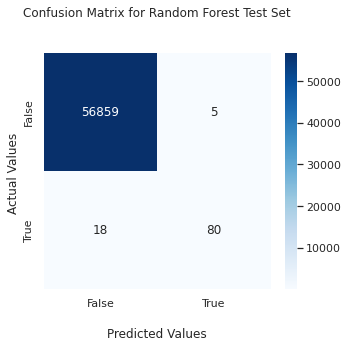

In [174]:
#@title
# #@title
# %%script echo skipping
# graphical confusion matrix for rf train set
confusion_matrix_plot(cnf_matrix_test_rf, 'rf-test', 'Random Forest Test Set' )

In [200]:
# add Random Forest - Basline
add_model_eval('Random Forest',rf_mcc_test, rf_recall_test, rf_f1_test)
df_metrics_table = view_models_eval(df_metrics_table)
display(df_metrics_table)

,model,mcc_test,recall_test,f1_score_test
2,Random Forest,0.88,0.82,0.87
0,Logistic Regression,0.74,0.65,0.73
1,Logistic Regression Grid,0.73,0.64,0.72


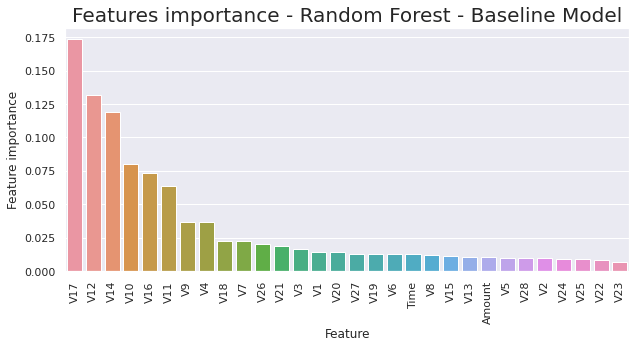

In [224]:
features = list(X_train.columns)

# Credits to Gabriel Preda
# https://www.kaggle.com/gpreda/credit-card-fraud-detection-predictive-models
plt.figure(figsize = (9,5))

feat_import = pd.DataFrame({'Feature': features, 'Feature importance': rf.feature_importances_})
feat_import = feat_import.sort_values(by='Feature importance',ascending=False)

g = sns.barplot(x='Feature',y='Feature importance',data=feat_import)
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_title('Features importance - Random Forest - Baseline Model',fontsize=20)
plt.savefig(f'{images_dir}/feature-importance-rf-baseline.png')
plt.show() 

In [175]:
#@title
%%script echo skipping
# random forest random search

parameter_grid = {'n_estimators': [100,200,400],
                 'max_depth': [5, 10, 15, None,],
                 'max_features': ['auto','sqrt',6, 8],
                  'min_samples_split' : [2,5,10],
                  'min_samples_leaf' : [1,2,4],
                  'bootstrap' : [True, False],
                  'criterion' : ['gini','entropy']}


rf_model = RandomForestClassifier(n_estimators = 100, random_state = 42)

strat_cv = StratifiedKFold(n_splits = 5, random_state = 42, shuffle=True)

rf_grid = RandomizedSearchCV(estimator = rf_model, 
                   param_distributions = parameter_grid, 
                   cv = strat_cv, 
                   scoring = 'recall', 
                   n_iter = 10,
                   n_jobs = -1,
                   refit = True)

rf_grid.fit(X_train_std, y_train)

rf_grid_best = rf_grid.best_estimator_ 
print(rf_grid_best)
best_params_rf_grid = rf_grid.best_params_, rf_grid.best_score_
print(best_params_rf_grid)

joblib.dump(best_params_rf_grid, '/drive/My Drive/Colab Notebooks//RF_GS_params.pkl')



skipping


In [176]:
#@title
# %%script echo skipping
# Open pickle file containing best grid params for Random Forest
data_rf_params = open('/drive/My Drive/Colab Notebooks//RF_GS_params.pkl','rb')
best_params_rf_grid = pickle.load(data_rf_params)
print(best_params_rf_grid)


({'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 8, 'max_depth': 15, 'criterion': 'gini', 'bootstrap': False}, 0.7867900032456994)


In [177]:
#@title
# #@title
# %%script echo skipping
# fit best params to model
rf_best_params = RandomForestClassifier(n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=8, max_depth=15, criterion='gini', bootstrap=False)
rf_best_params.fit(X_train_std, y_train)

RandomForestClassifier(bootstrap=False, max_depth=15, max_features=8,
                       n_estimators=200)

In [178]:
#@title
# #@title
# %%script echo skipping
# train predictions for best params 
y_train_pred_grid = rf_best_params.predict(X_train_std)

# train metrics
print(f'Random Forest (grid-train) MCC: {matthews_corrcoef(y_train, y_train_pred_grid)}')
print(f'Random Forest (grid-train) recall: {recall_score(y_train, y_train_pred_grid)}') 
print(f'Random Forest (grid-train) F1 score: {f1_score(y_train, y_train_pred_grid)}\n')
print(f'Random Forest Confusion Matrix (grid-train):\n\n {confusion_matrix(y_train, y_train_pred_grid)}\n')

# test predictions best params 
y_test_pred_grid = rf_best_params.predict(X_test_std)

# test metrics
rf_mcc_test_grid = metrics.matthews_corrcoef(y_test, y_test_pred_grid) # store as var
rf_recall_test_grid = metrics.recall_score(y_test, y_test_pred_grid) # store as var
rf_f1_test_grid = metrics.f1_score(y_test,y_test_pred_grid) # store as var

print(f'Random Forest (grid-test) MCC: {rf_mcc_test_grid}')
print(f'Random Forest (grid-test) Recall: {rf_recall_test_grid}')
print(f'Eandom Forest (grid-test) F1 score: {rf_f1_test_grid}\n')
print(f'Random Forest (grid-test):\n\n {confusion_matrix(y_test, y_test_pred_grid)}\n')

Random Forest (grid-train) MCC: 0.9544775138504047
Random Forest (grid-train) recall: 0.9111675126903553
Random Forest (grid-train) F1 score: 0.953519256308101

Random Forest Confusion Matrix (grid-train):

 [[227451      0]
 [    35    359]]

Random Forest (grid-test) MCC: 0.8821262209352536
Random Forest (grid-test) Recall: 0.826530612244898
Eandom Forest (grid-test) F1 score: 0.8804347826086957

Random Forest (grid-test):

 [[56859     5]
 [   17    81]]



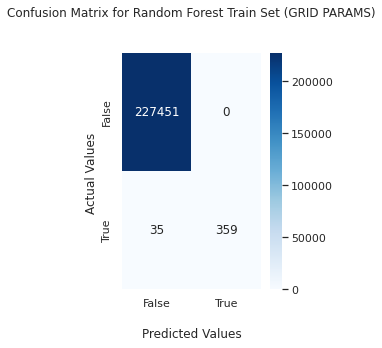

In [179]:
#@title
# #@title
# %%script echo skipping
# graphical confusion matrix for rf train set grid params
confusion_matrix_plot(confusion_matrix(y_train, y_train_pred_grid), 'rf-train-grid', 'Random Forest Train Set (GRID PARAMS)' )

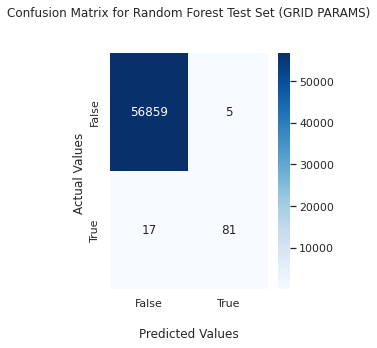

In [180]:
#@title
# #@title
# %%script echo skipping
# graphical confusion matrix for rf test set with grid params
confusion_matrix_plot(confusion_matrix(y_test, y_test_pred_grid), 'rf-test-grid', 'Random Forest Test Set (GRID PARAMS)' )

In [201]:
# add Random Forest Grid
add_model_eval('Random Forest Grid',rf_mcc_test_grid, rf_recall_test_grid, rf_f1_test_grid)
df_metrics_table = view_models_eval(df_metrics_table)
display(df_metrics_table)

,model,mcc_test,recall_test,f1_score_test
3,Random Forest Grid,0.88,0.83,0.88
0,Random Forest,0.88,0.82,0.87
1,Logistic Regression,0.74,0.65,0.73
2,Logistic Regression Grid,0.73,0.64,0.72


<h2><b>3. DNN - Deep Learning </b></h2>

In [181]:
# #@title
# %%script echo skipping
# build sequential keras model
dnn = Sequential([
Dense(input_dim = 30, units = 30, activation = 'relu'),
Dense(units = 20, activation = 'relu'),
# dropout to minimise overfitting
Dropout(0.4),
Dense(units =1, activation = 'sigmoid'),])

In [182]:
# #@title
# %%script echo skipping
# early stopping when val_loss has not minimized over 5 epochs
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15) # val_loss to prevent overfitting
# compile and fit model
dnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
dnn.fit(X_train_val_std, y_train_val, batch_size = 32, epochs = 100, callbacks = [es], validation_data = [X_test_val_std, y_test_val])

Epoch 1/100
5697/5697 [==============================] - 10s 2ms/step - loss: 0.0145 - accuracy: 0.9971 - val_loss: 0.0047 - val_accuracy: 0.9993
Epoch 2/100
5697/5697 [==============================] - 9s 2ms/step - loss: 0.0044 - accuracy: 0.9994 - val_loss: 0.0039 - val_accuracy: 0.9992
Epoch 3/100
5697/5697 [==============================] - 9s 2ms/step - loss: 0.0038 - accuracy: 0.9993 - val_loss: 0.0042 - val_accuracy: 0.9993
Epoch 4/100
5697/5697 [==============================] - 9s 2ms/step - loss: 0.0032 - accuracy: 0.9993 - val_loss: 0.0047 - val_accuracy: 0.9993
Epoch 5/100
5697/5697 [==============================] - 9s 2ms/step - loss: 0.0031 - accuracy: 0.9994 - val_loss: 0.0042 - val_accuracy: 0.9993
Epoch 6/100
5697/5697 [==============================] - 9s 2ms/step - loss: 0.0028 - accuracy: 0.9994 - val_loss: 0.0041 - val_accuracy: 0.9993
Epoch 7/100
5697/5697 [==============================] - 9s 2ms/step - loss: 0.0028 - accuracy: 0.9994 - val_loss: 0.0039 - val_a

In [183]:
# #@title
# %%script echo skipping
# train results
dnn_acc = dnn.evaluate(X_train_val_std, y_train_val)
print(dnn_acc)

5697/5697 [==============================] - 5s 941us/step - loss: 0.0012 - accuracy: 0.9997
[0.0011759484186768532, 0.999681830406189]


In [184]:
# #@title
# %%script echo skipping
# predict 
y_train_dnn_pred = dnn.predict(X_train_val_std)
# print metrics
train_dnn_mcc = matthews_corrcoef(y_train_val, y_train_dnn_pred.round())
train_dnn_recall = recall_score(y_train_val, y_train_dnn_pred.round())
train_dnn_f1 = f1_score(y_train_val, y_train_dnn_pred.round())
print(f'DNN train MCC: {train_dnn_mcc}')
print(f'DNN train recall: {train_dnn_recall}') 
print(f'DNN train F1 score: {train_dnn_f1}\n')
print(f'DNN train Confusion Matrix:\n\n {confusion_matrix(y_train_val, y_train_dnn_pred.round())}\n')

DNN train MCC: 0.9066922835057473
DNN train recall: 0.8374233128834356
DNN train F1 score: 0.9039735099337749

DNN train Confusion Matrix:

 [[181945      5]
 [    53    273]]



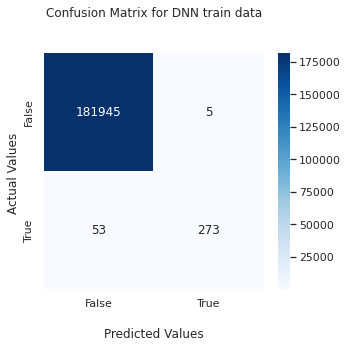

In [185]:
# #@title
# %%script echo skipping
# graphical confusion matrix for DNN train data
confusion_matrix_plot(confusion_matrix(y_train_val, y_train_dnn_pred.round()), 'dnn-train', 'DNN train data' )

In [186]:
# #@title
# %%script echo skipping
# test results
acc_test = dnn.evaluate(X_test_std, y_test)
print(acc_test)

1781/1781 [==============================] - 2s 965us/step - loss: 0.0043 - accuracy: 0.9994
[0.004318528342992067, 0.9993855357170105]


In [187]:
# #@title
# %%script echo skipping
# predict 
y_test_dnn_pred = dnn.predict(X_test_std)
# print metrics
test_dnn_mcc = matthews_corrcoef(y_test, y_test_dnn_pred.round())
test_dnn_recall = recall_score(y_test, y_test_dnn_pred.round())
test_dnn_f1 = f1_score(y_test, y_test_dnn_pred.round())
print(f'DNN test MCC: {test_dnn_mcc}')
print(f'DNN test recall: {test_dnn_recall}') 
print(f'DNN test F1 score: {test_dnn_f1}\n')
print(f'DNN test Confusion Matrix:\n\n {confusion_matrix(y_test, y_test_dnn_pred.round())}\n')



DNN test MCC: 0.8167272347868058
DNN test recall: 0.7959183673469388
DNN test F1 score: 0.8167539267015708

DNN test Confusion Matrix:

 [[56849    15]
 [   20    78]]



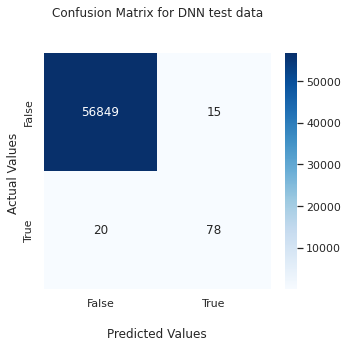

In [188]:
# #@title
# %%script echo skipping
# graphical confusion matrix for DNN test data
confusion_matrix_plot(confusion_matrix(y_test, y_test_dnn_pred.round()), 'dnn-test', 'DNN test data' )

In [203]:
# add DNN - Basline
add_model_eval('DNN',test_dnn_mcc, test_dnn_recall, test_dnn_f1)
df_metrics_table = view_models_eval(df_metrics_table)
display(df_metrics_table)

,model,mcc_test,recall_test,f1_score_test
0,Random Forest Grid,0.88,0.83,0.88
1,Random Forest,0.88,0.82,0.87
4,DNN,0.82,0.80,0.82
2,Logistic Regression,0.74,0.65,0.73
3,Logistic Regression Grid,0.73,0.64,0.72


In [202]:
#@title
%%script echo skipping
# grid search 
def DL_Model(activation= 'relu', units = 30, optimizer='relu', dropout = 0.4):
    model = Sequential()
    model.add(Dense(units=30, input_dim = X_train_std.shape[1] , activation= 'relu'))
    model.add(Dense(units, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer= 'adam', metrics=['accuracy'])
    return model

# Definying grid parameters

units = [25,15, 5]
epochs = [50,100]
batch_size = [32,64]
dropout_rate = [0,0.2,0.4,0.6,0.8]

# set params to dict
param_grid = dict(units=units , batch_size = batch_size, epochs = epochs, dropout=dropout_rate)
# set classifier wrapper
clf = KerasClassifier(build_fn= DL_Model, verbose= 0)
# instantiate grid
dnn_grid = RandomizedSearchCV(estimator= clf, param_distributions=param_grid, n_jobs=-1, cv=5)
# fit grid on original y_train (as we use cv)
dnn_grid.fit(X_train_std, y_train, callbacks = [es])
# find best estimator
dnn_grid_best = dnn_grid.best_estimator_ 
print(dnn_grid_best)
# find best params
best_params_dnn_grid = dnn_grid.best_params_, dnn_grid.best_score_
print(best_params_dnn_grid)
# save best params to google drive
joblib.dump(best_params_dnn_grid, '/drive/My Drive/Colab Notebooks//DNN_GS_params_new.pkl')



skipping


In [190]:
# #@title
# %%script echo skipping
# Open pickle file containing best grid params for Random Forest
data_dnn_params_new = open('/drive/My Drive/Colab Notebooks//DNN_GS_params_new.pkl','rb')
best_params_dnn_grid_new = pickle.load(data_dnn_params_new)[0]
print(best_params_dnn_grid_new)

{'units': 25, 'epochs': 100, 'dropout': 0.2, 'batch_size': 64}


In [191]:
# #@title
# %%script echo skipping
# fit model with best params
dnn_grid = Sequential([
Dense(input_dim = 30, units = 30, activation = 'relu'),
Dense(units = 25, activation = 'relu'),
Dropout(0.2),
Dense(units =1, activation = 'sigmoid')])

# early stopping until epochs loss does not minimise more past 5 epocs
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
# compile and fit model
dnn_grid.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
dnn_grid.fit(X_train_val_std, y_train_val, batch_size = 64, epochs = 100, callbacks = [es], validation_data = [X_test_val_std, y_test_val])

Epoch 1/100
2849/2849 [==============================] - 6s 2ms/step - loss: 0.0160 - accuracy: 0.9972 - val_loss: 0.0040 - val_accuracy: 0.9993
Epoch 2/100
2849/2849 [==============================] - 5s 2ms/step - loss: 0.0034 - accuracy: 0.9994 - val_loss: 0.0038 - val_accuracy: 0.9993
Epoch 3/100
2849/2849 [==============================] - 5s 2ms/step - loss: 0.0029 - accuracy: 0.9995 - val_loss: 0.0037 - val_accuracy: 0.9993
Epoch 4/100
2849/2849 [==============================] - 5s 2ms/step - loss: 0.0027 - accuracy: 0.9995 - val_loss: 0.0036 - val_accuracy: 0.9993
Epoch 5/100
2849/2849 [==============================] - 5s 2ms/step - loss: 0.0025 - accuracy: 0.9995 - val_loss: 0.0040 - val_accuracy: 0.9993
Epoch 6/100
2849/2849 [==============================] - 5s 2ms/step - loss: 0.0024 - accuracy: 0.9995 - val_loss: 0.0037 - val_accuracy: 0.9993
Epoch 7/100
2849/2849 [==============================] - 5s 2ms/step - loss: 0.0023 - accuracy: 0.9995 - val_loss: 0.0036 - val_ac

In [192]:
# #@title
# %%script echo skipping
# evaluate grid train results
acc_grid_train = dnn_grid.evaluate(X_train_val_std, y_train_val)
print(acc_grid_train)

# evaluate grid test results
acc_grid_test = dnn_grid.evaluate(X_test_std, y_test)
print(acc_grid_test)

5697/5697 [==============================] - 6s 979us/step - loss: 0.0012 - accuracy: 0.9997
[0.0011975604575127363, 0.9996873140335083]
1781/1781 [==============================] - 2s 949us/step - loss: 0.0034 - accuracy: 0.9994
[0.0033516271505504847, 0.9993680119514465]


In [193]:
# #@title
# %%script echo skipping
#predict train results from best params
y_train_pred_grid = dnn_grid.predict(X_train_val_std)
# predict classes from best params
y_train_pred_class = (y_train_pred_grid > 0.5).astype("int32")

# DNN grid train metrics
train_dnn_mcc_grid = matthews_corrcoef(y_train_val, y_train_pred_grid.round())
train_dnn_recall_grid = recall_score(y_train_val, y_train_pred_grid.round())
train_dnn_f1_grid = f1_score(y_train_val, y_train_pred_grid.round())
print(f'DNN grid-train MCC: {train_dnn_mcc_grid}')
print(f'DNN grid-train recall: {train_dnn_recall_grid}') 
print(f'DNN grid-train F1 score: {train_dnn_f1_grid}\n')
print(f'DNN grid-train Confusion Matrix:\n\n {confusion_matrix(y_train_val, y_train_pred_grid.round())}\n')

#predict test results from best params
y_test_pred_grid = dnn_grid.predict(X_test_std)
# predict classes from best params
y_test_pred_class = (y_test_pred_grid > 0.5).astype("int32")

# DNN grid test metrics
test_dnn_mcc_grid = matthews_corrcoef(y_test, y_test_pred_grid.round())
test_dnn_recall_grid = recall_score(y_test, y_test_pred_grid.round())
test_dnn_f1_grid = f1_score(y_test, y_test_pred_grid.round())
print(f'DNN grid-test MCC: {test_dnn_mcc_grid}')
print(f'DNN grid-test recall: {test_dnn_recall_grid}') 
print(f'DNN grid-test F1 score: {test_dnn_f1_grid}\n')
print(f'DNN grid-test Confusion Matrix:\n\n {confusion_matrix(y_test, y_test_pred_grid.round())}\n')



DNN grid-train MCC: 0.9088128063658866
DNN grid-train recall: 0.8558282208588958
DNN grid-train F1 score: 0.9073170731707318

DNN grid-train Confusion Matrix:

 [[181940     10]
 [    47    279]]

DNN grid-test MCC: 0.8057535849968727
DNN grid-test recall: 0.7551020408163265
DNN grid-test F1 score: 0.8043478260869564

DNN grid-test Confusion Matrix:

 [[56852    12]
 [   24    74]]



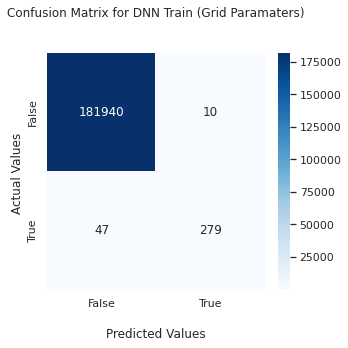

In [194]:
# #@title
# %%script echo skipping
# graphical confusion matrix for DNN train data (best params)
confusion_matrix_plot(confusion_matrix(y_train_val, y_train_pred_grid.round()), 'dnn-train-grid', 'DNN Train (Grid Paramaters)' )

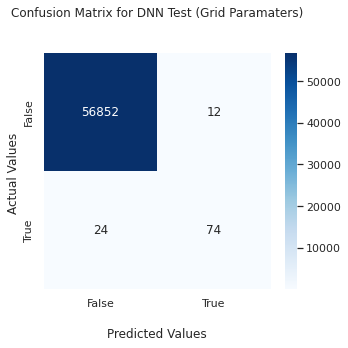

In [195]:
# #@title
# %%script echo skipping
# graphical confusion matrix for DNN test data (best params)
confusion_matrix_plot(confusion_matrix(y_test, y_test_pred_grid.round()), 'dnn-test-grid', 'DNN Test (Grid Paramaters)' )

In [204]:
# add DNN - Grid
add_model_eval('DNN Grid',test_dnn_mcc_grid, test_dnn_recall_grid, test_dnn_f1_grid)
df_metrics_table = view_models_eval(df_metrics_table)
display(df_metrics_table)

,model,mcc_test,recall_test,f1_score_test
0,Random Forest Grid,0.88,0.83,0.88
1,Random Forest,0.88,0.82,0.87
2,DNN,0.82,0.80,0.82
5,DNN Grid,0.81,0.76,0.80
3,Logistic Regression,0.74,0.65,0.73
4,Logistic Regression Grid,0.73,0.64,0.72


In [91]:
# #@title
# %%script echo skipping
# save model data to csv - google drive
# df_metrics_table.to_csv('/drive/My Drive/Colab Notebooks/model_results_table_new.csv', index = False)
# # open model data to pandas df - from
# df_metrics_table = pd.read_csv('/drive/My Drive/Colab Notebooks/model_results_table_new.csv',index_col=0, float_precision='round_trip')
# # df_metrics.drop(df_metrics.index, inplace=True)
# display(df_metrics_table)

# <h2><b>Analysis</b></h2><n>
<h3><i> Based off the confusion matrices, and the various metric evaluations above, it is apparent that the Random Forest model performs best in regard to the recall scores on the test data. The DNN model comes close second, with the Logistic Regression model lagging behind. However, all training scores do not match the testing scores well. This is called "model performance mistmatch". This can be due to overfitting, unpresentative data samples, or due to the nature of stochastic algorithms. I suspect in this case, the models may be overfitting due to the imbalance of data samples. To counteract this, we can balance the dataset/samples by either reducing the size of the dataset so the classes have an even representation, or by using the SMOTE oversampling method, to add 'fraud' class samples until they are balanced with the 'non fraud' class.</i></h3>


<h1><b> Resample Dataset - Under / Oversampling </h1></b>
<h4>Sampling is performed after data spliting, as the test data should be representative of real world samples (inbalanced). Only the training set will be sampled</h4>

<h2>SMOTE - Oversampling<h2>

In [92]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=42)

In [93]:
# split train further into a validation set for DNN
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=42)

In [94]:
# standardize (fit + transform) training features first, to calculate the mean/std from training data. Fit this onto test dataset and validation dataset
X_train[['Time','Amount']] = scaler.fit_transform(X_train[['Time','Amount']])
X_train_std = X_train.copy()
# Standardize test features
X_test[['Time','Amount']] = scaler.transform(X_test[['Time','Amount']])
# Standardize
X_test_std = X_test.copy()

# Standarize training validation set for DNN
X_train_val[['Time','Amount']] = scaler.fit_transform(X_train_val[['Time','Amount']])
# Standardize
X_train_val_std = X_train_val.copy()

# Standardize test features
X_test_val[['Time','Amount']] = scaler.transform(X_test_val[['Time','Amount']])
# Standardize
X_test_val_std = X_test_val.copy()


In [95]:
# oversample with SMOTE on training set 
sm = SMOTE(random_state=42)
X_train_oversample, y_train_oversample = sm.fit_resample(X_train_std, y_train) 

# oversample with SMOTE on validation training set 
X_train_val_oversample, y_train_val_oversample = sm.fit_resample(X_train_val_std, y_train_val) 

In [96]:
# use of counter method to check for balance of data
counter = Counter(y_train_oversample)
print(counter)

counter_val = Counter(y_train_val_oversample)
print(counter_val)

counter_y_test_val = Counter(y_test_val)
print(counter_y_test_val)

Counter({0: 227451, 1: 227451})
Counter({0: 181950, 1: 181950})
Counter({0: 45501, 1: 68})


In [97]:
# check for the balance of data
print(f' Fraud vs. Non Fraud: \n {np.round(y_train_oversample.value_counts().sort_values() / len(y_train_oversample) * 100, 2)}')

 Fraud vs. Non Fraud: 
 0    50.0
1    50.0
Name: Class, dtype: float64


<h2><b>1. Random Forest</h2></b>

In [98]:
#@title
# %%script echo skipping
# Open pickle file containing best grid params for Random Forest
data_rf_params = open('/drive/My Drive/Colab Notebooks//RF_GS_params.pkl','rb')
best_params_rf_grid = pickle.load(data_rf_params)[0]
print(best_params_rf_grid)

{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 8, 'max_depth': 15, 'criterion': 'gini', 'bootstrap': False}


In [99]:
#@title
# %%script echo skipping
# fit best params 
rf_smote = RandomForestClassifier(**best_params_rf_grid)
rf_smote.fit(X_train_oversample, y_train_oversample)

RandomForestClassifier(bootstrap=False, max_depth=15, max_features=8,
                       n_estimators=200)

In [100]:
#@title
# #@title
# %%script echo skipping
# predict on training data (oversampled)
y_train_pred_oversample = rf_smote.predict(X_train_oversample)
# print training metrics
print(f'Random Forest (train-Smote) MCC: {matthews_corrcoef(y_train_oversample, y_train_pred_oversample)}')
print(f'Random Forest (train-Smote) recall: {recall_score(y_train_oversample, y_train_pred_oversample)}') 
print(f'Random Forest (train-Smote) F1 score: {f1_score(y_train_oversample, y_train_pred_oversample)}\n')

Random Forest (train-Smote) MCC: 0.9995340741008767
Random Forest (train-Smote) recall: 1.0
Random Forest (train-Smote) F1 score: 0.9997670370630846



In [101]:
#@title
# #@title
# %%script echo skipping
# confusion matrix -train data- for Random Forest
cnf_matrix_train_rf_smote = metrics.confusion_matrix(y_train_oversample, y_train_pred_oversample)
print(f'Random Forest Confusion Matrix (train-Smote):\n\n {cnf_matrix_train_rf_smote}\n')

Random Forest Confusion Matrix (train-Smote):

 [[227345    106]
 [     0 227451]]



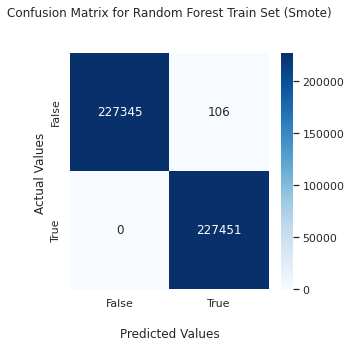

In [102]:
#@title
# #@title
# %%script echo skipping
# graphical confusion matrix for rf train set
confusion_matrix_plot(cnf_matrix_train_rf_smote, 'rf-train-smote', 'Random Forest Train Set (Smote)' )

In [103]:
#@title
# #@title
# %%script echo skipping
# predict on the test data (Smote)
y_test_pred_oversample = rf_smote.predict(X_test_std)
# save test metrics (Smote) to variables and print
rf_mcc_test_smote = metrics.matthews_corrcoef(y_test, y_test_pred_oversample) # store as var
rf_f1_test_smote = metrics.f1_score(y_test,y_test_pred_oversample) # store as var
rf_recall_test_smote = metrics.recall_score(y_test, y_test_pred_oversample) # store as var
print(f'Random Forest (test-Smote) MCC: {rf_mcc_test_smote}')
print(f'Random Forest (test-Smote) recall: {rf_recall_test_smote}')
print(f'Random Forest (test-Smote) F1 Score: {rf_f1_test_smote}\n')
print(f'Random Forest (test-Smote) Classification Report: \n\n{classification_report(y_test, y_test_pred_oversample)}')


Random Forest (test-Smote) MCC: 0.7226817283152085
Random Forest (test-Smote) recall: 0.826530612244898
Random Forest (test-Smote) F1 Score: 0.7168141592920354

Random Forest (test-Smote) Classification Report: 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.63      0.83      0.72        98

    accuracy                           1.00     56962
   macro avg       0.82      0.91      0.86     56962
weighted avg       1.00      1.00      1.00     56962



In [104]:
#@title
# #@title
# %%script echo skipping
# confusion matrix test for Random Forest (Smote)
cnf_matrix_test_rf_smote = metrics.confusion_matrix(y_test, y_test_pred_oversample)
print(f'Random Forest Confusion Matrix (test-Smote):\n\n {cnf_matrix_test_rf_smote}')

Random Forest Confusion Matrix (test-Smote):

 [[56817    47]
 [   17    81]]


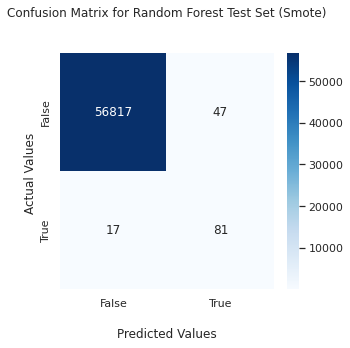

In [105]:
#@title
# #@title
# %%script echo skipping
# graphical confusion matrix for rf test set (smote)
confusion_matrix_plot(cnf_matrix_test_rf_smote, 'rf-test-smote', 'Random Forest Test Set (Smote)' )

In [205]:
# add RF Smote metrics
add_model_eval('Random Forest SMOTE',rf_mcc_test_smote, rf_recall_test_smote, rf_f1_test_smote)
df_metrics_table = view_models_eval(df_metrics_table)
# display(df_metrics_table)

,model,mcc_test,recall_test,f1_score_test
0,Random Forest Grid,0.88,0.83,0.88
6,Random Forest SMOTE,0.72,0.83,0.72
1,Random Forest,0.88,0.82,0.87
2,DNN,0.82,0.80,0.82
3,DNN Grid,0.81,0.76,0.80
4,Logistic Regression,0.74,0.65,0.73
5,Logistic Regression Grid,0.73,0.64,0.72


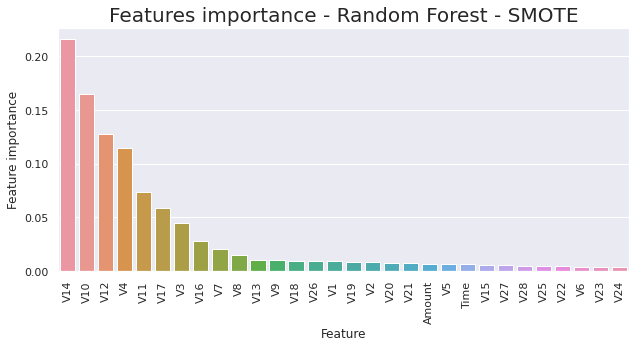

In [226]:
# set features to list
features = list(X_train.columns)
# fig size
plt.figure(figsize = (9,5))
# import feature important variables
feat_import = pd.DataFrame({'Feature': features, 'Feature importance': rf_smote.feature_importances_})
feat_import = feat_import.sort_values(by='Feature importance',ascending=False)
# seaborn plot
g = sns.barplot(x='Feature',y='Feature importance',data=feat_import)
g.set_xticklabels(g.get_xticklabels(),rotation=90)
# set title
g.set_title('Features importance - Random Forest - SMOTE',fontsize=20)
# save to onedrive
plt.savefig(f'{images_dir}/feature-importance-rf-smote.png')
plt.show() 

<h2>Imberlearn - Undersampling<h2>




In [107]:
rus = RandomUnderSampler(random_state=42)
X_train_undersample, y_train_undersample = rus.fit_resample(X_train_std, y_train)

In [108]:
# use of counter method to check for balance of data
counter = Counter(y_train_undersample)
print(counter)

Counter({0: 394, 1: 394})


In [109]:
#@title
# %%script echo skipping
# fit best params 
rf_under = RandomForestClassifier(**best_params_rf_grid)
rf_under.fit(X_train_undersample, y_train_undersample)

RandomForestClassifier(bootstrap=False, max_depth=15, max_features=8,
                       n_estimators=200)

In [110]:
# predict on training data (undersampled)
y_train_pred_undersample = rf_under.predict(X_train_undersample)
# print training metrics
print(f'Random Forest (train-Smote) MCC: {matthews_corrcoef(y_train_undersample, y_train_pred_undersample)}')
print(f'Random Forest (train-Smote) recall: {recall_score(y_train_undersample, y_train_pred_undersample)}') 
print(f'Random Forest (train-Smote) F1 score: {f1_score(y_train_undersample, y_train_pred_undersample)}\n')

Random Forest (train-Smote) MCC: 1.0
Random Forest (train-Smote) recall: 1.0
Random Forest (train-Smote) F1 score: 1.0



In [111]:
# predict on the test data (undersample)
y_test_pred_undersample = rf_under.predict(X_test_std)
# save test metrics (undersample) to variables and print
rf_mcc_test_under = metrics.matthews_corrcoef(y_test, y_test_pred_undersample) # store as var
rf_f1_test_under = metrics.f1_score(y_test,y_test_pred_undersample) # store as var
rf_recall_test_under = metrics.recall_score(y_test, y_test_pred_undersample) # store as var
print(f'Random Forest (test-under) MCC: {rf_mcc_test_under}')
print(f'Random Forest (test-under) recall: {rf_recall_test_under}')
print(f'Random Forest (test-under) F1 Score: {rf_f1_test_under}\n')
print(f'Random Forest (test-under) Classification Report: \n\n{classification_report(y_test, y_test_pred_undersample)}')


Random Forest (test-under) MCC: 0.16969227381682692
Random Forest (test-under) recall: 0.9183673469387755
Random Forest (test-under) F1 Score: 0.06401137980085349

Random Forest (test-under) Classification Report: 

              precision    recall  f1-score   support

           0       1.00      0.95      0.98     56864
           1       0.03      0.92      0.06        98

    accuracy                           0.95     56962
   macro avg       0.52      0.94      0.52     56962
weighted avg       1.00      0.95      0.97     56962



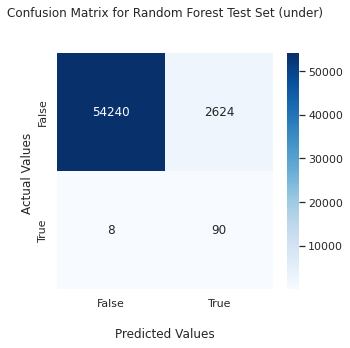

In [112]:
# %%script echo skipping
# graphical confusion matrix for rf test set (under)
confusion_matrix_plot(confusion_matrix(y_test, y_test_pred_undersample), 'rf-test-under', 'Random Forest Test Set (under)')

In [206]:
# add RF Undersampling Metrics
add_model_eval('Random Forest Undersampling',rf_mcc_test_under, rf_recall_test_under, rf_f1_test_under)
df_metrics_table = view_models_eval(df_metrics_table)
display(df_metrics_table)

,model,mcc_test,recall_test,f1_score_test
7,Random Forest Undersampling,0.17,0.92,0.06
0,Random Forest Grid,0.88,0.83,0.88
1,Random Forest SMOTE,0.72,0.83,0.72
2,Random Forest,0.88,0.82,0.87
3,DNN,0.82,0.80,0.82
4,DNN Grid,0.81,0.76,0.80
5,Logistic Regression,0.74,0.65,0.73
6,Logistic Regression Grid,0.73,0.64,0.72


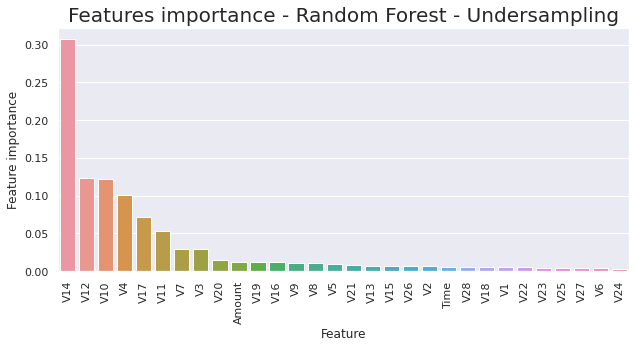

In [227]:
# set features to list
features = list(X_train.columns)
# fig size
plt.figure(figsize = (9,5))
# import feature important variables
feat_import = pd.DataFrame({'Feature': features, 'Feature importance': rf_under.feature_importances_})
feat_import = feat_import.sort_values(by='Feature importance',ascending=False)
# seaborn plot
g = sns.barplot(x='Feature',y='Feature importance',data=feat_import)
g.set_xticklabels(g.get_xticklabels(),rotation=90)
# set title
g.set_title('Features importance - Random Forest - Undersampling',fontsize=20)
# save to onedrive
plt.savefig(f'{images_dir}/feature-importance-rf-under.png')
plt.show() 

<h2>Smote and Undersampling<h2>

In [114]:
# instantiate smote and under
smote = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)

In [115]:
# resample by each method
X_train_mix, y_train_mix = smote.fit_resample(X_train_std, y_train)
X_train_mix, y_train_mix = under.fit_resample(X_train_mix, y_train_mix)

In [116]:
# use of counter method to check for balance of data
counter = Counter(y_train_mix)
print(counter)

Counter({0: 45490, 1: 22745})


In [117]:
# fit best params with mixed sampling methods
rf_mix= RandomForestClassifier(**best_params_rf_grid)
rf_mix.fit(X_train_mix, y_train_mix)

RandomForestClassifier(bootstrap=False, max_depth=15, max_features=8,
                       n_estimators=200)

In [118]:
# predict on training data (mix sampling methods)
y_train_pred_mix = rf_mix.predict(X_train_mix)
# print training metrics
print(f'Random Forest (train-mix) MCC: {matthews_corrcoef(y_train_mix, y_train_pred_mix)}')
print(f'Random Forest (train-mix) recall: {recall_score(y_train_mix, y_train_pred_mix)}') 
print(f'Random Forest (train-mix) F1 score: {f1_score(y_train_mix, y_train_pred_mix)}\n')

Random Forest (train-mix) MCC: 0.9995713280067393
Random Forest (train-mix) recall: 0.9995603429325126
Random Forest (train-mix) F1 score: 0.9997141789239936



In [119]:
# predict on the test data (mix sampling methods)
y_test_pred_mix = rf_mix.predict(X_test_std)
# save test metrics (mix sampling methods) to variables and print
rf_mcc_test_mix = metrics.matthews_corrcoef(y_test, y_test_pred_mix) # store as var
rf_f1_test_mix = metrics.f1_score(y_test,y_test_pred_mix) # store as var
rf_recall_test_mix = metrics.recall_score(y_test, y_test_pred_mix) # store as var
print(f'Random Forest (test-mix) MCC: {rf_mcc_test_mix}')
print(f'Random Forest (test-mix) recall: {rf_recall_test_mix}')
print(f'Random Forest (test-mix) F1 Score: {rf_f1_test_mix}\n')
print(f'Random Forest (test-mix) Classification Report: \n\n{classification_report(y_test, y_test_pred_mix)}')

Random Forest (test-mix) MCC: 0.7440307650248004
Random Forest (test-mix) recall: 0.8673469387755102
Random Forest (test-mix) F1 Score: 0.735930735930736

Random Forest (test-mix) Classification Report: 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.64      0.87      0.74        98

    accuracy                           1.00     56962
   macro avg       0.82      0.93      0.87     56962
weighted avg       1.00      1.00      1.00     56962



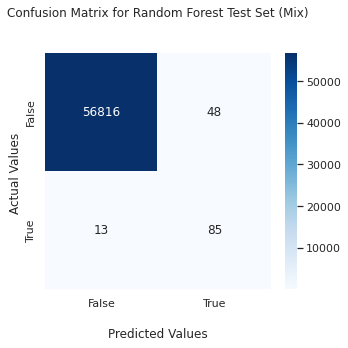

In [120]:
# %%script echo skipping
# graphical confusion matrix for rf test set (mixed)
confusion_matrix_plot(confusion_matrix(y_test, y_test_pred_mix), 'rf-test-mix', 'Random Forest Test Set (Mix)')

In [207]:
# add RF Smote + Undersampling Metrics
add_model_eval('Random Forst Hybrid Sampling',rf_mcc_test_mix, rf_recall_test_mix, rf_f1_test_mix)
df_metrics_table = view_models_eval(df_metrics_table)
display(df_metrics_table)

,model,mcc_test,recall_test,f1_score_test
0,Random Forest Undersampling,0.17,0.92,0.06
8,Random Forst Hybrid Sampling,0.74,0.87,0.74
1,Random Forest Grid,0.88,0.83,0.88
2,Random Forest SMOTE,0.72,0.83,0.72
3,Random Forest,0.88,0.82,0.87
4,DNN,0.82,0.80,0.82
5,DNN Grid,0.81,0.76,0.80
6,Logistic Regression,0.74,0.65,0.73
7,Logistic Regression Grid,0.73,0.64,0.72


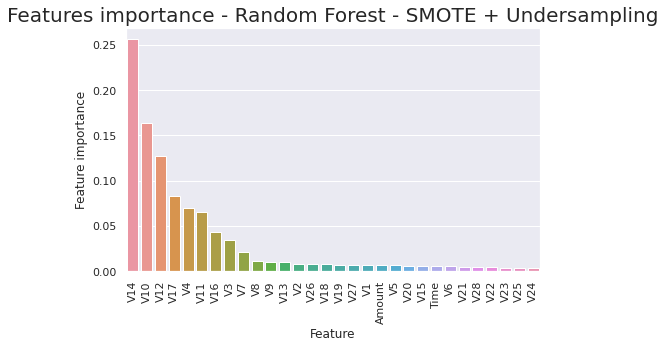

In [228]:
# set features to list
features = list(X_train.columns)
# fig size
plt.figure(figsize = (9,5))
# import feature important variables
feat_import = pd.DataFrame({'Feature': features, 'Feature importance': rf_mix.feature_importances_})
feat_import = feat_import.sort_values(by='Feature importance',ascending=False)
# seaborn plot
g = sns.barplot(x='Feature',y='Feature importance',data=feat_import)
g.set_xticklabels(g.get_xticklabels(),rotation=90)
# set title
g.set_title('Features importance - Random Forest - SMOTE + Undersampling',fontsize=20)
# save to onedrive
plt.savefig(f'{images_dir}/feature-importance-rf-mix.png')
plt.show() 

<h2>Class Weight Method<h2>

In [122]:
#@title
# %%script echo skipping
# fit best params for RF with class weighting
rf_weight = RandomForestClassifier(**best_params_rf_grid, class_weight = 'balanced')
rf_weight.fit(X_train_std, y_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=15,
                       max_features=8, n_estimators=200)

In [123]:
# predict on training data (weighted sampling method)
y_train_pred_weight = rf_weight.predict(X_train_std)
# print training metrics
print(f'Random Forest (train-weighted) MCC: {matthews_corrcoef(y_train, y_train_pred_weight)}')
print(f'Random Forest (train-weighted) recall: {recall_score(y_train, y_train_pred_weight)}') 
print(f'Random Forest (train-weighted) F1 score: {f1_score(y_train, y_train_pred_weight)}\n')

Random Forest (train-weighted) MCC: 0.9335197572560013
Random Forest (train-weighted) recall: 1.0
Random Forest (train-weighted) F1 score: 0.9314420803782506



In [124]:
# predict on the test data (weighed)
y_test_pred_weight = rf_weight.predict(X_test_std)
# save test metrics (weighted) to variables and print
rf_mcc_test_weight = metrics.matthews_corrcoef(y_test, y_test_pred_weight) # store as var
rf_f1_test_weight = metrics.f1_score(y_test,y_test_pred_weight) # store as var
rf_recall_test_weight = metrics.recall_score(y_test, y_test_pred_weight) # store as var
print(f'Random Forest (test-weight) MCC: {rf_mcc_test_weight}')
print(f'Random Forest (test-weight) recall: {rf_recall_test_weight}')
print(f'Random Forest (test-weight) F1 Score: {rf_f1_test_weight}')
print(f'Random Forest (test-weight) Classification Report: \n\n{classification_report(y_test, y_test_pred_weight)}')


Random Forest (test-weight) MCC: 0.760448378923786
Random Forest (test-weight) recall: 0.8061224489795918
Random Forest (test-weight) F1 Score: 0.7596153846153846
Random Forest (test-weight) Classification Report: 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.72      0.81      0.76        98

    accuracy                           1.00     56962
   macro avg       0.86      0.90      0.88     56962
weighted avg       1.00      1.00      1.00     56962



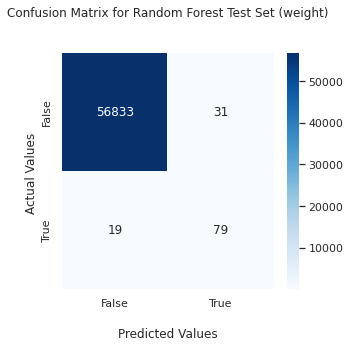

In [125]:
# %%script echo skipping
# graphical confusion matrix for rf test set (weight)
confusion_matrix_plot(confusion_matrix(y_test, y_test_pred_weight), 'rf-test-weight', 'Random Forest Test Set (weight)')

In [208]:
# add RF Weighted
add_model_eval('Random Forest Weighted',rf_mcc_test_weight, rf_recall_test_weight, rf_f1_test_weight)
df_metrics_table = view_models_eval(df_metrics_table)
display(df_metrics_table)

,model,mcc_test,recall_test,f1_score_test
0,Random Forest Undersampling,0.17,0.92,0.06
1,Random Forst Hybrid Sampling,0.74,0.87,0.74
2,Random Forest Grid,0.88,0.83,0.88
3,Random Forest SMOTE,0.72,0.83,0.72
4,Random Forest,0.88,0.82,0.87
9,Random Forest Weighted,0.76,0.81,0.76
5,DNN,0.82,0.80,0.82
6,DNN Grid,0.81,0.76,0.80
7,Logistic Regression,0.74,0.65,0.73
8,Logistic Regression Grid,0.73,0.64,0.72


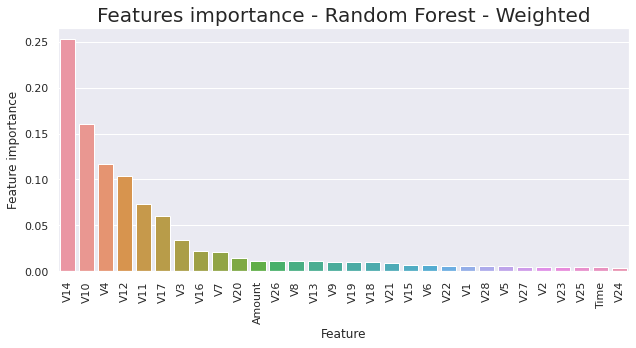

In [229]:
# set features to list
features = list(X_train.columns)
# fig size
plt.figure(figsize = (9,5))
# import feature important variables
feat_import = pd.DataFrame({'Feature': features, 'Feature importance': rf_weight.feature_importances_})
feat_import = feat_import.sort_values(by='Feature importance',ascending=False)
# seaborn plot
g = sns.barplot(x='Feature',y='Feature importance',data=feat_import)
g.set_xticklabels(g.get_xticklabels(),rotation=90)
# set title
g.set_title('Features importance - Random Forest - Weighted',fontsize=20)
# save to onedrive
plt.savefig(f'{images_dir}/feature-importance-rf-weight.png')
plt.show() 

<h2>Class Weight Method - Params<h2>

In [127]:
#@title
# %%script echo skipping
# fit best params for RF with class weighting - manual
rf_weight_manual = RandomForestClassifier(**best_params_rf_grid, class_weight = {0: 0.1, 1: 0.9})
rf_weight_manual.fit(X_train_std, y_train)

RandomForestClassifier(bootstrap=False, class_weight={0: 0.1, 1: 0.9},
                       max_depth=15, max_features=8, n_estimators=200)

In [128]:
# predict on training data (weighted sampling method- manual)
y_train_pred_weight_manual = rf_weight_manual.predict(X_train_std)
# print training metrics
print(f'Random Forest (train-weighted-manual) MCC: {matthews_corrcoef(y_train, y_train_pred_weight_manual)}')
print(f'Random Forest (train-weighted-manual) recall: {recall_score(y_train, y_train_pred_weight_manual)}') 
print(f'Random Forest (train-weighted-manual) F1 score: {f1_score(y_train, y_train_pred_weight_manual)}\n')

Random Forest (train-weighted-manual) MCC: 0.972940444795215
Random Forest (train-weighted-manual) recall: 0.9467005076142132
Random Forest (train-weighted-manual) F1 score: 0.9726205997392439



In [129]:
# predict on the test data (weighted - manual)
y_test_pred_weight_manual = rf_weight_manual.predict(X_test_std)
# save test metrics (weighted- manual) to variables and print
rf_mcc_test_weight_manual = metrics.matthews_corrcoef(y_test, y_test_pred_weight_manual) # store as var
rf_f1_test_weight_manual = metrics.f1_score(y_test,y_test_pred_weight_manual) # store as var
rf_recall_test_weight_manual = metrics.recall_score(y_test, y_test_pred_weight_manual) # store as var
print(f'Random Forest (test-weight-manual) MCC: {rf_mcc_test_weight_manual}')
print(f'Random Forest (test-weight-manual) recall: {rf_recall_test_weight_manual}')
print(f'Random Forest (test-weight-manual) F1 Score: {rf_f1_test_weight_manual}')
print(f'Random Forest (test-weight-manual) Classification Report: \n\n{classification_report(y_test, y_test_pred_weight_manual)}')


Random Forest (test-weight-manual) MCC: 0.8922575264930523
Random Forest (test-weight-manual) recall: 0.8163265306122449
Random Forest (test-weight-manual) F1 Score: 0.888888888888889
Random Forest (test-weight-manual) Classification Report: 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.98      0.82      0.89        98

    accuracy                           1.00     56962
   macro avg       0.99      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962



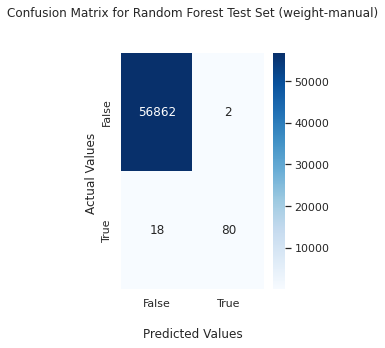

In [130]:
# %%script echo skipping
# graphical confusion matrix for rf test set (weight-manual)
confusion_matrix_plot(confusion_matrix(y_test, y_test_pred_weight_manual), 'rf-test-weight-manual', 'Random Forest Test Set (weight-manual)')

In [209]:
# add RF Manual Params
add_model_eval('Random Forest Weighted Params',rf_mcc_test_weight_manual, rf_recall_test_weight_manual, rf_f1_test_weight_manual)
df_metrics_table = view_models_eval(df_metrics_table)
display(df_metrics_table)

,model,mcc_test,recall_test,f1_score_test
0,Random Forest Undersampling,0.17,0.92,0.06
1,Random Forst Hybrid Sampling,0.74,0.87,0.74
2,Random Forest Grid,0.88,0.83,0.88
3,Random Forest SMOTE,0.72,0.83,0.72
4,Random Forest,0.88,0.82,0.87
10,Random Forest Weighted Params,0.89,0.82,0.89
5,Random Forest Weighted,0.76,0.81,0.76
6,DNN,0.82,0.80,0.82
7,DNN Grid,0.81,0.76,0.80
8,Logistic Regression,0.74,0.65,0.73


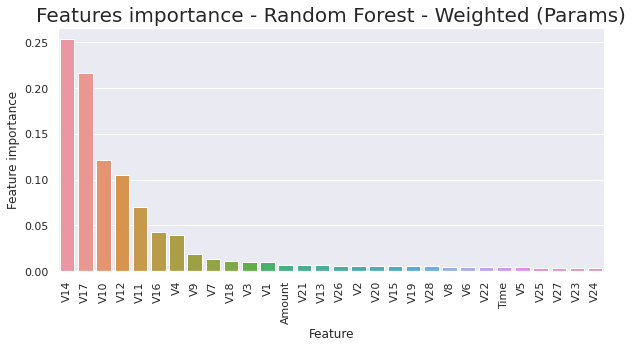

In [230]:
# set features to list
features = list(X_train.columns)
# fig size
plt.figure(figsize = (9,5))
# import feature important variables
feat_import = pd.DataFrame({'Feature': features, 'Feature importance': rf_weight_manual.feature_importances_})
feat_import = feat_import.sort_values(by='Feature importance',ascending=False)
# seaborn plot
g = sns.barplot(x='Feature',y='Feature importance',data=feat_import)
g.set_xticklabels(g.get_xticklabels(),rotation=90)
# set title
g.set_title('Features importance - Random Forest - Weighted (Params)',fontsize=20)
# save to onedrive
plt.savefig(f'{images_dir}/feature-importance-rf-weighted-params.png')
plt.show() 

<h1> Metric Scores Sorted by Recall </h1>

In [210]:
# #@title
# %%script echo skipping
# save model data to csv - google drive
df_metrics_table.to_csv('/drive/My Drive/Colab Notebooks/model_results_table.csv', index = False)
# open model data to pandas df - from
df_metrics_table = pd.read_csv('/drive/My Drive/Colab Notebooks/model_results_table.csv',index_col=0, float_precision='round_trip')
# df_metrics.drop(df_metrics.index, inplace=True)
display(df_metrics_table)

,mcc_test,recall_test,f1_score_test
model,,,
Random Forest Undersampling,0.17,0.92,0.06
Random Forst Hybrid Sampling,0.74,0.87,0.74
Random Forest Grid,0.88,0.83,0.88
Random Forest SMOTE,0.72,0.83,0.72
Random Forest,0.88,0.82,0.87
Random Forest Weighted Params,0.89,0.82,0.89
Random Forest Weighted,0.76,0.81,0.76
DNN,0.82,0.80,0.82
DNN Grid,0.81,0.76,0.80
